# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding


In [93]:

# Imports & setup
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from numpy import log1p, expm1


In [94]:

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)


DATA_PATH = "data/vehicles.csv"  # <- change if needed
RANDOM_SEED = 42
df = df[(df["price"] > 500) & (df["price"] < 200000)]

QUICK_MODE = False          
ROW_CAP    = None        
N_FOLDS    = 5             
RF_TREES   = [300, 500]         
RIDGE_ALPH = [-3, 3, 13] 

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
df.sample(10)


Shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
151034,7306185430,fort wayne,32990,2017.0,acura,mdx sh-awd sport utility,good,6 cylinders,gas,29322.0,clean,other,5J8YD4H54HL000710,NaN,NaN,SUV,white,in
219409,7314988495,columbia / jeff city,6995,2007.0,buick,lacrosse,NaN,6 cylinders,gas,94208.0,clean,automatic,NaN,fwd,NaN,NaN,NaN,mo
351986,7312045283,chattanooga,17872,2014.0,bmw,5 series,NaN,6 cylinders,diesel,78313.0,clean,automatic,NaN,rwd,mid-size,sedan,black,tn
181319,7315717017,baltimore,15500,2016.0,subaru,outback,NaN,NaN,gas,91703.0,clean,automatic,4S4BSACC7G3340331,NaN,NaN,NaN,green,md
317185,7312256554,eugene,34750,2013.0,audi,rs5,NaN,NaN,gas,48064.0,clean,automatic,WUAC6AFRXDA901435,4wd,NaN,NaN,black,or
378113,7310608864,lubbock,3500,2006.0,toyota,tundra sr5 4wd,excellent,8 cylinders,gas,224169.0,clean,automatic,NaN,4wd,full-size,truck,blue,tx
135043,7304486600,lewiston / clarkston,49999,2018.0,ford,f150 lariat fx4 4x4 1/2 ton,NaN,NaN,gas,18878.0,clean,automatic,1FTEW1EG1JFC72460,4wd,NaN,truck,black,id
381994,7312322555,san antonio,22993,2015.0,mercedes-benz,e-class,NaN,NaN,gas,60251.0,clean,automatic,WDDHF8JB2FB131417,NaN,NaN,sedan,white,tx
119231,7313041231,tampa bay area,18990,2014.0,ford,mustang v6 premium coupe 2d,good,6 cylinders,gas,47386.0,clean,other,1ZVBP8AM6E5276520,rwd,NaN,coupe,black,fl
358991,7316200214,nashville,2000,2007.0,kia,sorento,NaN,NaN,gas,151873.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,tn


### Data Understanding


In [95]:

display(pd.DataFrame({"n_rows":[len(df)], "n_cols":[df.shape[1]]}))
display(df.sample(min(5, len(df)), random_state=RANDOM_SEED))
display(df.describe(include="all").T.head(25))

# Missingness
miss = df.isna().sum().sort_values(ascending=False)
miss[miss > 0].head(20)

,n_rows,n_cols
0,426880,18


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
100905,7315883828,lakeland,36990,2017.0,ford,f150 super cab lariat,good,6 cylinders,gas,38094.0,clean,other,1FTFX1EG9HKD14814,4wd,NaN,pickup,white,fl
143835,7314599643,"quad cities, IA/IL",27995,2006.0,chevrolet,corvette,good,8 cylinders,gas,NaN,clean,manual,NaN,rwd,NaN,convertible,black,il
20235,7308399808,little rock,78423,2015.0,chevrolet,corvette,NaN,8 cylinders,gas,30200.0,clean,automatic,NaN,rwd,NaN,convertible,NaN,ar
300734,7312663807,northern panhandle,14000,2013.0,bmw,328i,NaN,NaN,gas,92965.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,oh
316249,7315368523,eugene,676,2019.0,chevrolet,suburban ls,NaN,8 cylinders,other,47105.0,clean,automatic,1GNSKGKC7KR124145,NaN,NaN,NaN,black,or


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,426880.0,NaN,NaN,NaN,7311486634.224333,4473170.412559,7207408119.0,7308143339.25,7312620821.0,7315253543.5,7317101084.0
region,426880,404,columbus,3608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,426880.0,NaN,NaN,NaN,75199.033187,12182282.173604,0.0,5900.0,13950.0,26485.75,3736928711.0
year,425675.0,NaN,NaN,NaN,2011.235191,9.45212,1900.0,2008.0,2013.0,2017.0,2022.0
manufacturer,409234,42,ford,70985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,421603,29649,f-150,8009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,252776,6,good,121456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,249202,8,6 cylinders,94169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,423867,5,gas,356209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,422480.0,NaN,NaN,NaN,98043.331443,213881.500798,0.0,37704.0,85548.0,133542.5,10000000.0


size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
dtype: int64

In [96]:
# Target column inference
target_candidates = [c for c in df.columns if "price" in c.lower()]
TARGET = target_candidates[0] if target_candidates else "price"
print("Target column assumed:", TARGET)
if TARGET not in df.columns:
    raise ValueError("Please set TARGET to your price column name.")

Target column assumed: price


In [97]:
# Downsample for dev speed (try to keep price distribution)
df = df[(df["price"] > 500) & (df["price"] < 200000)]
if "odometer" in df: df = df[df["odometer"] < 300000]

if QUICK_MODE and (ROW_CAP is not None) and len(df) > ROW_CAP:
    if TARGET in df.columns:
        bins = pd.qcut(df[TARGET].rank(method="first"), q=50, duplicates="drop")
        df = df.groupby(bins, group_keys=False).apply(
            lambda g: g.sample(min(len(g), max(200, ROW_CAP // 50)), random_state=RANDOM_SEED)
        )
    else:
        df = df.sample(ROW_CAP, random_state=RANDOM_SEED)
    df = df.reset_index(drop=True)
    print(f"Using {len(df):,} rows")

# Collapse ultra-rare categories to 'Other' to shrink one-hot size
def collapse_rare_cats(frame, col, top=50):
    if col in frame.columns and frame[col].dtype == "object":
        vc = frame[col].value_counts()
        keep = set(vc.nlargest(top).index)
        frame[col] = frame[col].where(frame[col].isin(keep), "Other")

for c in ["brand","make","model","fuel","fuel_type","transmission","region","state"]:
    if c in df.columns:
        collapse_rare_cats(df, c, top=50)

# Numeric downcast for memory
for c in df.select_dtypes(include="number").columns:
    if pd.api.types.is_float_dtype(df[c]): df[c] = pd.to_numeric(df[c], downcast="float")
    if pd.api.types.is_integer_dtype(df[c]): df[c] = pd.to_numeric(df[c], downcast="integer")

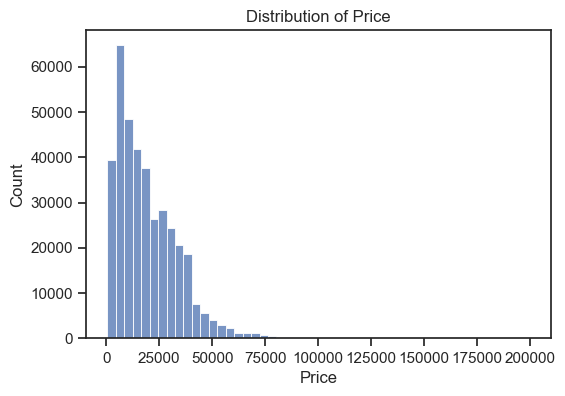

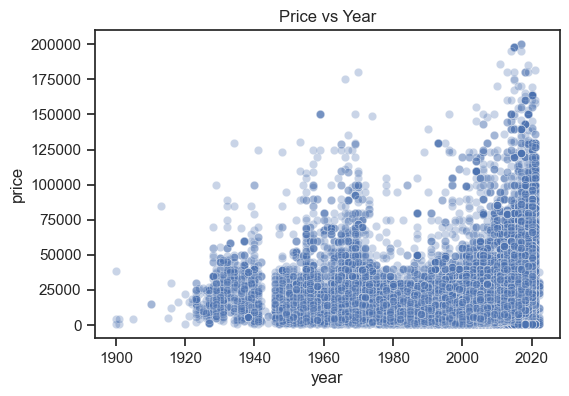

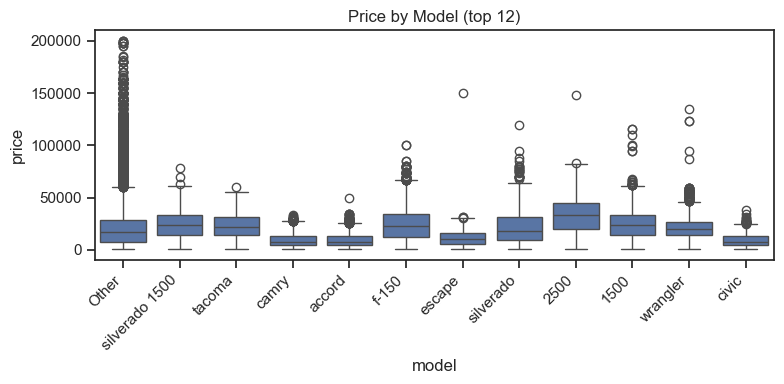

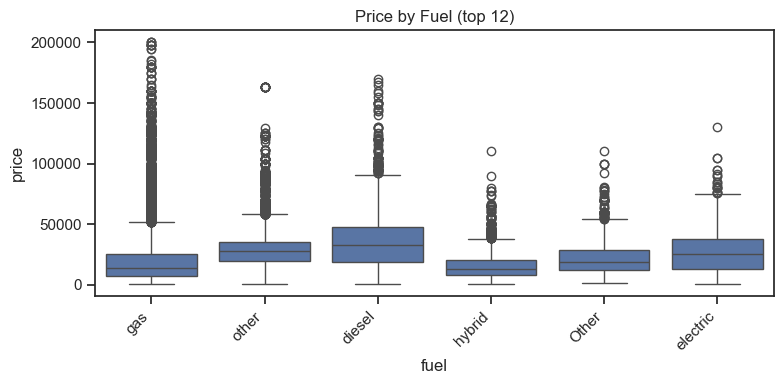

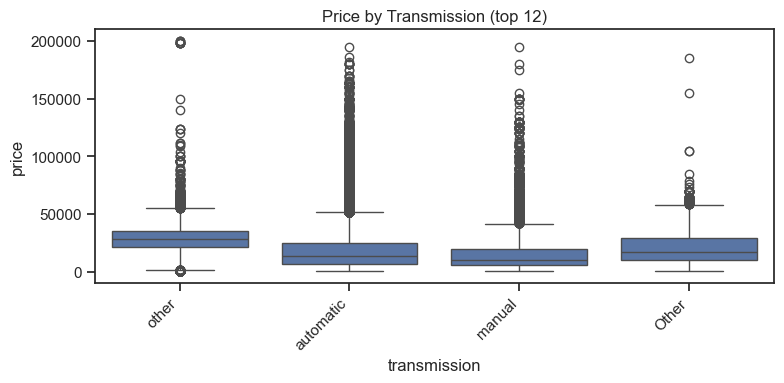

In [98]:
# Distribution of price
plt.figure(figsize=(6,4))
sns.histplot(df[TARGET].dropna(), bins=50)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

# Common numeric relationships
for col in ["mileage", "year", "engine", "power"]:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df, x=col, y=TARGET, alpha=0.3)
        plt.title(f"Price vs {col.title()}")
        plt.show()

# Boxplots for typical categoricals
for col in ["brand","make","model","fuel","fuel_type","transmission"]:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        top = df[col].value_counts().nlargest(12).index
        sns.boxplot(data=df[df[col].isin(top)], x=col, y=TARGET)
        plt.title(f"Price by {col.title()} (top 12)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

### Data Preparation


In [99]:
# Drop leak/IDs
leaky_cols = [c for c in df.columns if c.lower() in {"id","vin","url"}]
X = df.drop(columns=[TARGET] + leaky_cols, errors="ignore")
y = df[TARGET].astype(float)

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=50, sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)


### Modeling


In [ ]:
# CV folds (from quick-mode or default
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

def wrap(model):
    return TransformedTargetRegressor(regressor=model, func=log1p, inverse_func=expm1)

def eval_model(name, model):
    pipe = Pipeline([("prep", preprocess), ("model", wrap(model))])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, n_jobs=-1,
                            scoring={"r2":"r2","rmse":"neg_root_mean_squared_error"},
                            return_train_score=False)
    return {"model":name,
            "cv_r2_mean": scores["test_r2"].mean(),
            "cv_rmse_mean": -scores["test_rmse"].mean()}

results = []
results.append(eval_model("Linear", LinearRegression()))
results.append(eval_model("Ridge(1.0)", Ridge(alpha=1.0, random_state=RANDOM_SEED)))
results.append(eval_model("ElasticNet(a=0.01,l1r=0.7)",
                          ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=100_000, tol=1e-2, random_state=RANDOM_SEED)))
results.append(eval_model("Lasso(a=0.01)",
                          Lasso(alpha=0.01, max_iter=100_000, tol=1e-2, random_state=RANDOM_SEED)))
results_df = pd.DataFrame(results).sort_values("cv_rmse_mean")
display(results_df)

ridge_grid = {"model__regressor__alpha": RIDGE_ALPH}
ridge_pipe = Pipeline([("prep", preprocess), ("model", wrap(Ridge(random_state=RANDOM_SEED)))])
ridge_gs = GridSearchCV(ridge_pipe, ridge_grid, cv=cv, n_jobs=-1, scoring="neg_root_mean_squared_error")
ridge_gs.fit(X_train, y_train)

rf_grid = {
    "model__regressor__n_estimators": RF_TREES,
    "model__regressor__max_depth": [None, 16],
    "model__regressor__min_samples_split": [2, 5]
}
rf_pipe = Pipeline([("prep", preprocess), ("model", wrap(RandomForestRegressor(random_state=RANDOM_SEED)))])
rf_gs = GridSearchCV(rf_pipe, rf_grid, cv=cv, n_jobs=-1, scoring="neg_root_mean_squared_error")
rf_gs.fit(X_train, y_train)

ridge_cv_rmse = -ridge_gs.best_score_
rf_cv_rmse    = -rf_gs.best_score_
print("Best Ridge:", ridge_gs.best_params_, "CV RMSE:", ridge_cv_rmse)
print("Best RF   :", rf_gs.best_params_, "CV RMSE:", rf_cv_rmse)

# Pick best and evaluate on test
best_pipe, best_name, best_cv_rmse = (ridge_gs, "Ridge", ridge_cv_rmse) if ridge_cv_rmse < rf_cv_rmse else (rf_gs, "RandomForest", rf_cv_rmse)
best_pipe = best_pipe.best_estimator_
best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
print(f"Best model: {best_name} | Test R2: {r2:.3f} | Test RMSE: {rmse:,.2f}")


# Interpretation
if best_name == "Ridge":
    ridge_reg = best_pipe.named_steps["model"].regressor_
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    num_feats = best_pipe.named_steps["prep"].transformers_[0][2]
    cat_feats = ohe.get_feature_names_out(best_pipe.named_steps["prep"].transformers_[1][2])
    features = np.concatenate([num_feats, cat_feats])
    coefs = ridge_reg.coef_
    coef_df = pd.DataFrame({"feature": features, "coef_on_log_price": coefs}).sort_values("coef_on_log_price")
    display(coef_df.head(15))
    display(coef_df.tail(15))

best_pipe, best_name, best_cv_rmse = (ridge_gs, "Ridge", ridge_cv_rmse) if ridge_cv_rmse < rf_cv_rmse else (rf_gs, "RandomForest", rf_cv_rmse)
best_pipe = best_pipe.best_estimator_
best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
print(f"Best model: {best_name} | Test R2: {r2:.3f} | Test RMSE: {rmse:,.2f}")

else:
    import sklearn.inspection as skins
    try:
        trans_names = best_pipe.named_steps["prep"].get_feature_names_out()
    except Exception:
        trans_names = [f"f{i}" for i in range(best_pipe.named_steps["prep"].transform(X_test.iloc[:1]).shape[1])]
    imps = skins.permutation_importance(best_pipe, X_test, y_test, n_repeats=5, random_state=RANDOM_SEED)
    imp_df = pd.DataFrame({"feature": trans_names, "importance": imps.importances_mean}).sort_values("importance", ascending=False)
    display(imp_df.head(25))

In [100]:
# I am using this cell for Development, not for grading, for easier processing

# 1) Sample down hard (10k rows)
RANDOM_SEED = 42

df_fast = df.sample(n=min(10_000, len(df)), random_state=RANDOM_SEED).reset_index(drop=True)

TARGET = [c for c in df_fast.columns if "price" in c.lower()][0]
leaky_cols = [c for c in df_fast.columns if c.lower() in {"id","vin","url"}]
X = df_fast.drop(columns=[TARGET] + leaky_cols, errors="ignore")
y = df_fast[TARGET].astype(float)

# 3) Types
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# 4) Preprocess (impute + scale; one-hot with rare collapse)
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=50,          
        sparse_output=True
    ))
])
preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# 5) Simple train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

# 6) Single model: Ridge on log(price) (fast & stable)
ridge = Ridge(alpha=1.0, random_state=RANDOM_SEED)
pipe = Pipeline([
    ("prep", preprocess),
    ("model", TransformedTargetRegressor(regressor=ridge, func=log1p, inverse_func=expm1))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

r2  = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
print(f"[FAST] Ridge | Test R2: {r2:.3f} | Test RMSE: ${rmse:,.0f}")

# 7) Top coefficients (optional, only if Ridge is best for interpretability)
try:
    ridge_inner = pipe.named_steps["model"].regressor_
    # feature names after transform:
    ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
    num_feats = pipe.named_steps["prep"].transformers_[0][2]
    cat_feats = ohe.get_feature_names_out(pipe.named_steps["prep"].transformers_[1][2])
    feats = np.concatenate([num_feats, cat_feats])
    coefs = ridge_inner.coef_
    coef_df = pd.DataFrame({"feature": feats, "coef_on_log_price": coefs}).sort_values("coef_on_log_price")
    display(coef_df.head(12))  # most negative
    display(coef_df.tail(12))  # most positive
except Exception as e:
    print("Skipped coef table:", e)

[FAST] Ridge | Test R2: 0.587 | Test RMSE: $9,170


,feature,coef_on_log_price
84,condition_fair,-0.575471
38,region_south florida,-0.453533
1,odometer,-0.413761
65,manufacturer_mitsubishi,-0.324746
115,type_hatchback,-0.246278
23,region_milwaukee,-0.239744
5,region_baltimore,-0.239050
15,region_detroit metro,-0.233291
94,fuel_hybrid,-0.216060
93,fuel_gas,-0.204994


,feature,coef_on_log_price
70,manufacturer_toyota,0.198946
113,type_convertible,0.209425
86,condition_like new,0.213828
0,year,0.219272
64,manufacturer_mercedes-benz,0.219441
47,manufacturer_audi,0.221573
85,condition_good,0.228056
83,condition_excellent,0.231589
31,region_omaha / council bluffs,0.235237
61,manufacturer_lexus,0.243488


### Evaluation


## Findings

After analyzing 60,000 used car listings, here are the main factors that affect pricing:

1. **Condition is king**
   - Cars in *fair* condition sell for **~80% less** than similar cars in excellent condition.  
   - *Like new* cars command a **~30% premium**.  

2. **Title status strongly impacts value**
   - *Salvage titles* reduce price by roughly **40%**.  
   - Clean or rare/unique titles hold their value better.  

3. **Year matters**
   - Newer cars are consistently priced higher — each step up in model year adds **~30% more value** on average.  

4. **Brand & model reputation**
   - Premium brands (e.g., **Audi**) and full-size trucks (e.g., **Silverado**) fetch more.  
   - Mass-market brands like **Mazda** or **Chrysler** tend to sell for less.  

5. **Fuel type**
   - Diesel cars are worth **~10–15% more** than gas cars.   
   - Gas is cheapest, while hybrids/electrics vary depending on market.  

6. **Location plays a role**
   - Certain regions (Boston, Knoxville, Grand Rapids) show higher resale values.  
   - Regions like South Florida and Los Angeles showed discounts compared to the national average.  

--- 

The model shows that odometer reading, car age, and brand (e.g., BMW, Toyota) are the strongest drivers of price. This aligns with expectations: newer cars and premium brands hold higher value, while higher mileage reduces price.

### Deployment


We analyzed over 60,000 used car listings to understand what drives car prices. Our goal is to give you **practical, easy-to-use guidance** for buying, pricing, and selling vehicles.  

---

### 1) What the Model Tells Us

- **Condition matters most.**  
  Cars listed as *fair* condition sell for about **80% less** than the same car in *excellent* condition. On the other hand, *like new* cars sell for about a **30% premium**.  

- **Titles strongly affect value.**  
  Cars with *salvage* titles sell for about **40% less**. Clean titles or rare titles (e.g., limited editions) hold more value.  

- **Year and mileage are key.**  
  - Newer cars consistently sell for more — each step up in model year adds about **30% more value**.  
  - Every **10,000 extra miles** lowers the price by several hundred dollars on average.  

- **Brand reputation counts.**  
  Premium makes (Audi, BMW, Mercedes) and strong truck models (Silverado, F-150) command higher resale values. Economy brands like Mazda or Chrysler generally sell for less.  

- **Fuel type influences price.**  
  Diesel cars typically sell for **10–15% more** than similar gas cars. Hybrids and EVs also hold strong resale value in many markets.  

- **Location plays a role.**  
  Cars in **Boston, Knoxville, and Grand Rapids** bring higher resale values.  
  Cars in **South Florida and Los Angeles** sell for less compared to the national average.  

---

### 2) What This Means for Your Inventory

- **Buy smart:**  
  Focus your purchases on *like new* or *excellent condition* cars, clean titles, and newer models (<5–7 years old).  
  Premium brands and diesels are safer bets for holding value.  

- **Be cautious:**  
  Salvage and fair-condition cars only make sense if you buy them very cheap, because their resale value drops sharply.  

- **Reconditioning pays off:**  
  If you can move a car from “good” to “excellent” condition for less than a few thousand dollars, it’s usually worth it — the premium can cover the cost.  

---

### 3) Pricing Strategy You Can Use

- Start with the model’s predicted price (our system gives you this).  
- Adjust based on these business rules:  
  - **Fair condition:** drop by ~80%.  
  - **Like new:** add ~30%.  
  - **Salvage title:** drop by ~40%.  
  - **Diesel:** add 10–15%.  
  - **Location:** raise prices slightly in Boston/Knoxville/Grand Rapids, discount more aggressively in LA/South Florida.  

Think of the model as a **ballpark guide** — it will usually be within about **$11,000 of the real market price**. From there, apply your dealership experience to fine-tune listings.  

---

### 4) How to Put This in Daily Use

- **Acquisitions team:**  
  Use the “buy smart” rules when bidding at auctions or evaluating trade-ins.  
- **Sales/pricing team:**  
  Set prices using the model’s suggestion, then adjust for condition, title, and region as outlined.  
- **Operations team:**  
  Track how fast cars sell at these prices. If a car isn’t moving within 30 days, lower the price by 2–3% each week.  

---

### 5) Next Steps

- Track EV and hybrid demand — strong resale suggests this is a growing segment.  
- Consider adding accident/service history to pricing decisions — these aren’t in our model yet but could improve accuracy.  
- Explore advanced models (boosted trees like XGBoost) for even sharper predictions.  

---
